In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import torch

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight

I_max = 120  # Maximum outer iterations
sigma_n2 = 1.0  # Noise variance
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel

# Convert to tensors
omega_t = torch.tensor(omega, dtype=torch.float32, device=device)
sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
mu_t = torch.tensor(mu, dtype=torch.float32, device=device)
lambda_t = torch.tensor(lambda_, dtype=torch.float32, device=device)

# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Convert to tensors
theta_d_t = torch.tensor(theta_d, dtype=torch.float32, device=device)
theta_grid_t = torch.tensor(theta_grid, dtype=torch.float32, device=device)
B_d_t = torch.tensor(B_d, dtype=torch.float32, device=device)

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

k_t = torch.tensor(k, dtype=torch.float32, device=device)
d_t = torch.tensor(d, dtype=torch.float32, device=device)

import h5py
SNR_dB_array = np.arange(0, 12.1, 0.1)
# Load Psi data (from MATLAB .mat file)
with h5py.File('Psi_all.mat', 'r') as f:
    Psi_h5 = f['Psi_all']

    # If stored as MATLAB complex structure (real/imag parts separate)
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j * imag
    else:
        Psi_all = np.array(Psi_h5)

# Ensure Psi_all has shape: (num_SNRs, M, N)
Psi_all = np.squeeze(Psi_all)  # remove singleton dimensions if any


def compute_psi(snr_db):
    """
    Selects the Psi matrix corresponding to the closest SNR value.
    """
    # Find index of closest SNR
    idx = np.argmin(np.abs(SNR_dB_array - snr_db))

    # Select corresponding Psi
    Psi = Psi_all[idx, :, :]

    return Psi

Training config: epochs=70, channels/epoch=1000, SNR=12 dB

Training UPGANet (J=1)
Epoch [1/70] | Loss: 3.406042 | μ=-0.053190, λ=-0.026532
Epoch [2/70] | Loss: 4.824307 | μ=-0.002810, λ=-0.011990
Epoch [3/70] | Loss: 4.972167 | μ=0.010695, λ=-0.004545
Epoch [4/70] | Loss: 3.204020 | μ=0.008972, λ=-0.006110
Epoch [5/70] | Loss: 4.532536 | μ=0.035628, λ=-0.009628
Epoch [6/70] | Loss: 4.313839 | μ=0.034181, λ=-0.010970
Epoch [7/70] | Loss: 4.515878 | μ=0.088473, λ=-0.012329
Epoch [8/70] | Loss: 4.069306 | μ=0.093172, λ=-0.012278
Epoch [9/70] | Loss: 4.317219 | μ=0.096260, λ=-0.013050
Epoch [10/70] | Loss: 4.333491 | μ=0.079176, λ=-0.013149
Epoch [11/70] | Loss: 4.896334 | μ=0.068867, λ=-0.012829
Epoch [12/70] | Loss: 4.609833 | μ=0.080643, λ=-0.012804
Epoch [13/70] | Loss: 5.248190 | μ=0.009194, λ=-0.013655
Epoch [14/70] | Loss: 4.860941 | μ=-0.005975, λ=-0.013458
Epoch [15/70] | Loss: 4.388333 | μ=-0.042966, λ=-0.013462
Epoch [16/70] | Loss: 3.265054 | μ=-0.075377, λ=-0.013423
Epoch [17

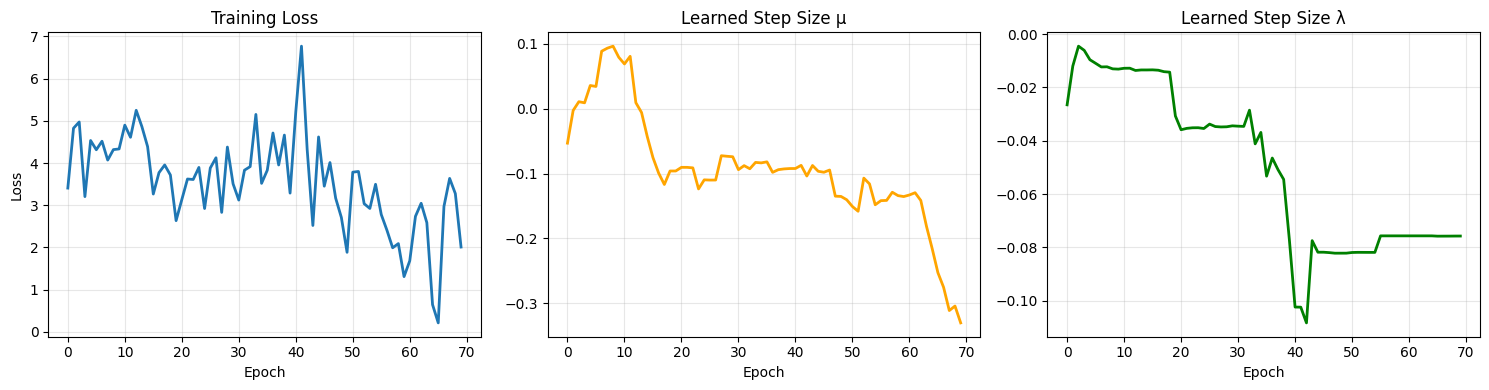


Training complete ✅


In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# ==== Config ====
num_epochs = 70
num_channels = 1000
snr_min, snr_max = 0, 12

from lib.dnn import UPGANet, upganet_loss
from lib.support_functions_torch import (
    generate_channel_torch_batch,
    proposed_initialization_torch,
)

print(f"Training config: epochs={num_epochs}, channels/epoch={num_channels}, SNR={snr_max} dB")

# # ==== Pre-generate channel batch ====
# H_batch = generate_channel_batch(N, M, L=20, batch_size=num_channels, device=device)
# print(f"Channel batch shape: {H_batch.shape}")

# ==== Training ====
J_values = [1]

for J in J_values:
    print(f"\nTraining UPGANet (J={J})")
    model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    loss_history, mu_history, lambda_history = [], [], []

    for epoch in range(num_epochs):
        total_loss = 0.0

        H_batch = generate_channel_torch_batch(N, M, L=20, batch_size=num_channels, device=device)

        for ch_idx in range(num_channels):
            H_ch = H_batch[ch_idx]
            # snr_db = snr_max
            snr_db = np.random.randint(snr_min, snr_max + 1)
            
            Psi = compute_psi(snr_db)
            Psi = torch.tensor(Psi, dtype=torch.complex64, device=device)

            P_BS = sigma_n2 * 10**(snr_db / 10)
            P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)

            A0, D0 = proposed_initialization_torch(H_ch, theta_d_t, N, M, K, P_BS_t, device=device)
            A_final, D_final = model(H_ch, A0, D0, Psi, sigma_n2_t, P_BS_t)

            loss = upganet_loss(H_ch, A_final, D_final, Psi, sigma_n2_t, omega)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_channels
        loss_history.append(avg_loss)

        with torch.no_grad():
            mu_mean = model.layers[0].mu.mean().item()
            lambda_val = model.layers[0].lambda_.item()
        mu_history.append(mu_mean)
        lambda_history.append(lambda_val)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.6f} | μ={mu_mean:.6f}, λ={lambda_val:.6f}")

    # ==== Save model ====
    save_path = f"upganet_J{J}_final.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved: {save_path}")

    # ==== Plot results ====
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(loss_history, linewidth=2)
    axes[0].set_title("Training Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(mu_history, linewidth=2, color="orange")
    axes[1].set_title("Learned Step Size μ")
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(lambda_history, linewidth=2, color="green")
    axes[2].set_title("Learned Step Size λ")
    axes[2].set_xlabel("Epoch")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\nTraining complete ✅")
